In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [4]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [5]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",
                                     with_l2=True,with_l3=True,with_l4=True,with_l5=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [6]:
gc.collect()

0

# cv

In [7]:
from sklearn.linear_model import Ridge

In [8]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [9]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [10]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [11]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                        ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl',
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    ,
                    'l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl'
                   ])

In [12]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [13]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [14]:
import cPickle as pickle
# indexes=rrvf_data.get_train_valid_indexes()

In [15]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [16]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge(alpha=3)
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [17]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [18]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [19]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [20]:
EXCLUDE_HARD=True
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,trainidx=make_Xy(train_data_from_gen)
    validX,validy,valididx=trainX,trainy,trainidx
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [21]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [29]:
reload(rrvf_data)

<module 'rrvf_data' from '../python/rrvf2017/rrvf_data.py'>

In [30]:
j=99
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, None,ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
pickle.dump(validpreds, open('l5_3000_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (250740, 2)
train/valid (187881, 2)
train has 187881 records out of 389630 records
no valid set
train # (5803, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 5803 records
no valid set
1467
0
(250740, 1, 40) (250740, 7, 72) (250740, 1) (250740, 1)
(250740, 544) (250740,) (250740,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.17929873936e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2415965 0.2415965
[0.2415965]
-1 mean score 0.2415965
0.213443055749


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931172 -0.002062  0.228101    7  2017-04-16
472     2.507290  2.539030 -0.031740  0.235611    1  2017-04-17
473     2.661330  2.671438 -0.010108  0.249989    2  2017-04-18
474     2.754815  2.745672  0.009143  0.205644    3  2017-04-19
475     2.713762  2.715616 -0.001854  0.231823    4  2017-04-20
476     2.999000  2.989722  0.009278  0.156437    5  2017-04-21
477     3.075529  3.076669 -0.001140  0.186496    6  2017-04-22

0.213443055749


pred         y     error    error2  day        date
dayidx                                                         
471     2.931172  2.929110 -0.002062  0.228101    7  2017-04-16
472     2.539030  2.507290 -0.031740  0.235611    1  2017-04-17
473     2.671438  2.661330 -0.010108  0.249989    2  2017-04-18
474     2.745672  2.754815  0.009143  0.205644    3  2017-04-19
475     2.715616  2.713762 -0.001854  0.231823    4  2017-04-20
476     2.989722  2.999000  0.009278  0.156437    5  2017-04-21
477     3.076669  3.075529 -0.001140  0.186496    6  2017-04-22

(829, 1088)


2
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (250457, 2)
train/valid (187713, 2)
train has 187713 records out of 389630 records
no valid set
train # (6632, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 6632 records
no valid set
1466
0
(250457, 1, 40) (250457, 7, 72) (250457, 1) (250457, 1)
(250457, 544) (250457,) (250457,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.63191462752e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24621363 0.24621363
[0.24621363]
-1 mean score 0.24621363
0.216264382005


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927748  0.001362  0.233660    7  2017-04-16
472     2.507290  2.529981 -0.022691  0.237895    1  2017-04-17
473     2.661330  2.667439 -0.006110  0.250109    2  2017-04-18
474     2.754815  2.751967  0.002847  0.212599    3  2017-04-19
475     2.713762  2.719759 -0.005997  0.235658    4  2017-04-20
476     2.999000  2.991956  0.007043  0.159458    5  2017-04-21
477     3.075529  3.065354  0.010175  0.184472    6  2017-04-22

0.216264382005


pred         y     error    error2  day        date
dayidx                                                         
471     2.927748  2.929110  0.001362  0.233660    7  2017-04-16
472     2.529981  2.507290 -0.022691  0.237895    1  2017-04-17
473     2.667439  2.661330 -0.006110  0.250109    2  2017-04-18
474     2.751967  2.754815  0.002847  0.212599    3  2017-04-19
475     2.719759  2.713762 -0.005997  0.235658    4  2017-04-20
476     2.991956  2.999000  0.007043  0.159458    5  2017-04-21
477     3.065354  3.075529  0.010175  0.184472    6  2017-04-22

(829, 1088)


3
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (250230, 2)
train/valid (187571, 2)
train has 187571 records out of 389630 records
no valid set
train # (7461, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 7461 records
no valid set
1465
0
(250230, 1, 40) (250230, 7, 72) (250230, 1) (250230, 1)
(250230, 544) (250230,) (250230,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.59702353908e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24829791 0.24829791
[0.24829791]
-1 mean score 0.24829791
0.220970541239


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909645  0.019465  0.232167    7  2017-04-16
472     2.507290  2.517823 -0.010533  0.238507    1  2017-04-17
473     2.661330  2.657070  0.004260  0.262398    2  2017-04-18
474     2.754815  2.766331 -0.011516  0.221661    3  2017-04-19
475     2.713762  2.721002 -0.007240  0.240694    4  2017-04-20
476     2.999000  2.983873  0.015126  0.161898    5  2017-04-21
477     3.075529  3.060881  0.014648  0.189468    6  2017-04-22

0.220970541239


pred         y     error    error2  day        date
dayidx                                                         
471     2.909645  2.929110  0.019465  0.232167    7  2017-04-16
472     2.517823  2.507290 -0.010533  0.238507    1  2017-04-17
473     2.657070  2.661330  0.004260  0.262398    2  2017-04-18
474     2.766331  2.754815 -0.011516  0.221661    3  2017-04-19
475     2.721002  2.713762 -0.007240  0.240694    4  2017-04-20
476     2.983873  2.999000  0.015126  0.161898    5  2017-04-21
477     3.060881  3.075529  0.014648  0.189468    6  2017-04-22

(829, 1088)


4
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (250028, 2)
train/valid (187454, 2)
train has 187454 records out of 389630 records
no valid set
train # (8290, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 8290 records
no valid set
1464
0
(250028, 1, 40) (250028, 7, 72) (250028, 1) (250028, 1)
(250028, 544) (250028,) (250028,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.08435468937e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24984707 0.24984707
[0.24984707]
-1 mean score 0.24984707
0.220999032259


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910312  0.018798  0.239833    7  2017-04-16
472     2.507290  2.515115 -0.007824  0.236168    1  2017-04-17
473     2.661330  2.631853  0.029477  0.260155    2  2017-04-18
474     2.754815  2.753315  0.001500  0.216016    3  2017-04-19
475     2.713762  2.718408 -0.004646  0.240827    4  2017-04-20
476     2.999000  2.968222  0.030778  0.166211    5  2017-04-21
477     3.075529  3.055064  0.020465  0.187784    6  2017-04-22

0.22099904716


pred         y     error    error2  day        date
dayidx                                                         
471     2.910312  2.929110  0.018798  0.239833    7  2017-04-16
472     2.515115  2.507290 -0.007824  0.236168    1  2017-04-17
473     2.631853  2.661330  0.029477  0.260155    2  2017-04-18
474     2.753315  2.754815  0.001500  0.216016    3  2017-04-19
475     2.718408  2.713762 -0.004646  0.240827    4  2017-04-20
476     2.968222  2.999000  0.030778  0.166211    5  2017-04-21
477     3.055064  3.075529  0.020465  0.187784    6  2017-04-22

(829, 1088)


5
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (249776, 2)
train/valid (187288, 2)
train has 187288 records out of 389630 records
no valid set
train # (9119, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 9119 records
no valid set
1463
0
(249776, 1, 40) (249776, 7, 72) (249776, 1) (249776, 1)
(249776, 544) (249776,) (249776,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.3444360876e-11 / 5.96046447754e-08
  RuntimeWarning)


0.25173518 0.25173518
[0.25173518]
-1 mean score 0.25173518
0.223513558507


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916371  0.012739  0.235040    7  2017-04-16
472     2.507290  2.526930 -0.019640  0.244969    1  2017-04-17
473     2.661330  2.625552  0.035778  0.263324    2  2017-04-18
474     2.754815  2.734712  0.020102  0.215142    3  2017-04-19
475     2.713762  2.704595  0.009166  0.247224    4  2017-04-20
476     2.999000  2.968598  0.030402  0.169102    5  2017-04-21
477     3.075529  3.051662  0.023867  0.189794    6  2017-04-22

0.223513528705


pred         y     error    error2  day        date
dayidx                                                         
471     2.916371  2.929110  0.012739  0.235040    7  2017-04-16
472     2.526930  2.507290 -0.019640  0.244969    1  2017-04-17
473     2.625552  2.661330  0.035778  0.263324    2  2017-04-18
474     2.734712  2.754815  0.020102  0.215142    3  2017-04-19
475     2.704595  2.713762  0.009166  0.247224    4  2017-04-20
476     2.968598  2.999000  0.030402  0.169102    5  2017-04-21
477     3.051662  3.075529  0.023867  0.189794    6  2017-04-22

(829, 1088)


6
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 15.133374
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (249513, 2)
train/valid (187122, 2)
train has 187122 records out of 389630 records
no valid set
train # (9948, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 9948 records
no valid set
1461
0
(249513, 1, 40) (249513, 7, 72) (249513, 1) (249513, 1)
(249513, 544) (249513,) (249513,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.87945419917e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2527062 0.2527062
[0.2527062]
-1 mean score 0.2527062
0.226857155561


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926185  0.002925  0.242044    7  2017-04-16
472     2.507290  2.535208 -0.027918  0.251283    1  2017-04-17
473     2.661330  2.629252  0.032078  0.269714    2  2017-04-18
474     2.754815  2.738030  0.016785  0.217514    3  2017-04-19
475     2.713762  2.722182 -0.008421  0.248362    4  2017-04-20
476     2.999000  2.955434  0.043565  0.170638    5  2017-04-21
477     3.075529  3.069544  0.005985  0.188444    6  2017-04-22

0.226857155561


pred         y     error    error2  day        date
dayidx                                                         
471     2.926185  2.929110  0.002925  0.242044    7  2017-04-16
472     2.535208  2.507290 -0.027918  0.251283    1  2017-04-17
473     2.629252  2.661330  0.032078  0.269715    2  2017-04-18
474     2.738030  2.754815  0.016785  0.217514    3  2017-04-19
475     2.722182  2.713762 -0.008421  0.248362    4  2017-04-20
476     2.955434  2.999000  0.043565  0.170638    5  2017-04-21
477     3.069544  3.075529  0.005985  0.188444    6  2017-04-22

(829, 1088)


7
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 16.310143
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (249239, 2)
train/valid (186927, 2)
train has 186927 records out of 389630 records
no valid set
train # (10777, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 10777 records
no valid set
1460
0
(249239, 1, 40) (249239, 7, 72) (249239, 1) (249239, 1)
(249239, 544) (249239,) (249239,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.02487539289e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2550162 0.2550162
[0.2550162]
-1 mean score 0.2550162
0.227511763573


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921872  0.007238  0.245333    7  2017-04-16
472     2.507290  2.545278 -0.037987  0.252160    1  2017-04-17
473     2.661330  2.638572  0.022757  0.271120    2  2017-04-18
474     2.754815  2.730767  0.024048  0.217453    3  2017-04-19
475     2.713762  2.713663  0.000098  0.250924    4  2017-04-20
476     2.999000  2.978406  0.020594  0.164118    5  2017-04-21
477     3.075529  3.090020 -0.014491  0.191474    6  2017-04-22

0.227511763573


pred         y     error    error2  day        date
dayidx                                                         
471     2.921872  2.929110  0.007238  0.245333    7  2017-04-16
472     2.545278  2.507290 -0.037987  0.252160    1  2017-04-17
473     2.638572  2.661330  0.022757  0.271120    2  2017-04-18
474     2.730767  2.754815  0.024048  0.217453    3  2017-04-19
475     2.713663  2.713762  0.000098  0.250924    4  2017-04-20
476     2.978406  2.999000  0.020594  0.164118    5  2017-04-21
477     3.090020  3.075529 -0.014491  0.191474    6  2017-04-22

(829, 1088)


8
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 17.574337
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (248949, 2)
train/valid (186700, 2)
train has 186700 records out of 389630 records
no valid set
train # (11606, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 11606 records
no valid set
1458
0
(248949, 1, 40) (248949, 7, 72) (248949, 1) (248949, 1)
(248949, 544) (248949,) (248949,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.09753525712e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25889376 0.25889376
[0.25889376]
-1 mean score 0.25889376
0.232456639409


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936124 -0.007014  0.254483    7  2017-04-16
472     2.507290  2.548908 -0.041617  0.248183    1  2017-04-17
473     2.661330  2.652244  0.009086  0.275437    2  2017-04-18
474     2.754815  2.737511  0.017303  0.228510    3  2017-04-19
475     2.713762  2.715004 -0.001243  0.255016    4  2017-04-20
476     2.999000  2.965640  0.033359  0.173354    5  2017-04-21
477     3.075529  3.090685 -0.015155  0.192213    6  2017-04-22

0.232456609607


pred         y     error    error2  day        date
dayidx                                                         
471     2.936124  2.929110 -0.007014  0.254483    7  2017-04-16
472     2.548908  2.507290 -0.041617  0.248183    1  2017-04-17
473     2.652244  2.661330  0.009086  0.275437    2  2017-04-18
474     2.737511  2.754815  0.017303  0.228510    3  2017-04-19
475     2.715004  2.713762 -0.001243  0.255016    4  2017-04-20
476     2.965640  2.999000  0.033359  0.173354    5  2017-04-21
477     3.090685  3.075529 -0.015155  0.192213    6  2017-04-22

(829, 1088)


9
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 18.806503
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (248667, 2)
train/valid (186481, 2)
train has 186481 records out of 389630 records
no valid set
train # (12435, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 12435 records
no valid set
1456
0
(248667, 1, 40) (248667, 7, 72) (248667, 1) (248667, 1)
(248667, 544) (248667,) (248667,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.01859479185e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26108408 0.26108408
[0.26108408]
-1 mean score 0.26108408
0.231876730919


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923962  0.005148  0.255141    7  2017-04-16
472     2.507290  2.554736 -0.047446  0.248220    1  2017-04-17
473     2.661330  2.669041 -0.007712  0.277821    2  2017-04-18
474     2.754815  2.734304  0.020511  0.230357    3  2017-04-19
475     2.713762  2.716865 -0.003103  0.249379    4  2017-04-20
476     2.999000  2.969891  0.029109  0.170602    5  2017-04-21
477     3.075529  3.084686 -0.009156  0.191617    6  2017-04-22

0.231876730919


pred         y     error    error2  day        date
dayidx                                                         
471     2.923962  2.929110  0.005148  0.255141    7  2017-04-16
472     2.554736  2.507290 -0.047446  0.248220    1  2017-04-17
473     2.669041  2.661330 -0.007712  0.277821    2  2017-04-18
474     2.734304  2.754815  0.020511  0.230357    3  2017-04-19
475     2.716865  2.713762 -0.003103  0.249379    4  2017-04-20
476     2.969891  2.999000  0.029109  0.170602    5  2017-04-21
477     3.084686  3.075529 -0.009156  0.191617    6  2017-04-22

(829, 1088)


10
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 19.926521
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (248451, 2)
train/valid (186330, 2)
train has 186330 records out of 389630 records
no valid set
train # (13264, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 13264 records
no valid set
1455
0
(248451, 1, 40) (248451, 7, 72) (248451, 1) (248451, 1)
(248451, 544) (248451,) (248451,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.24985019135e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26173636 0.26173636
[0.26173636]
-1 mean score 0.26173636
0.231341123581


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924526  0.004584  0.250521    7  2017-04-16
472     2.507290  2.540415 -0.033125  0.248955    1  2017-04-17
473     2.661330  2.670324 -0.008994  0.277707    2  2017-04-18
474     2.754815  2.749106  0.005709  0.226295    3  2017-04-19
475     2.713762  2.724378 -0.010617  0.250995    4  2017-04-20
476     2.999000  2.974649  0.024350  0.171821    5  2017-04-21
477     3.075529  3.092941 -0.017412  0.193094    6  2017-04-22

0.23134110868


pred         y     error    error2  day        date
dayidx                                                         
471     2.924526  2.929110  0.004584  0.250521    7  2017-04-16
472     2.540415  2.507290 -0.033125  0.248955    1  2017-04-17
473     2.670324  2.661330 -0.008994  0.277707    2  2017-04-18
474     2.749106  2.754815  0.005709  0.226295    3  2017-04-19
475     2.724378  2.713762 -0.010617  0.250995    4  2017-04-20
476     2.974649  2.999000  0.024350  0.171821    5  2017-04-21
477     3.092941  3.075529 -0.017412  0.193094    6  2017-04-22

(829, 1088)


11
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 21.05768
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (248225, 2)
train/valid (186196, 2)
train has 186196 records out of 389630 records
no valid set
train # (14093, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 14093 records
no valid set
1454
0
(248225, 1, 40) (248225, 7, 72) (248225, 1) (248225, 1)
(248225, 544) (248225,) (248225,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.75013542126e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26253048 0.26253048
[0.26253048]
-1 mean score 0.26253048
0.231851890683


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913957  0.015153  0.248578    7  2017-04-16
472     2.507290  2.544998 -0.037707  0.250757    1  2017-04-17
473     2.661330  2.662456 -0.001126  0.278935    2  2017-04-18
474     2.754815  2.725981  0.028834  0.228560    3  2017-04-19
475     2.713762  2.732547 -0.018785  0.250550    4  2017-04-20
476     2.999000  2.981350  0.017650  0.173065    5  2017-04-21
477     3.075529  3.073877  0.001653  0.192518    6  2017-04-22

0.231851890683


pred         y     error    error2  day        date
dayidx                                                         
471     2.913957  2.929110  0.015153  0.248578    7  2017-04-16
472     2.544998  2.507290 -0.037707  0.250757    1  2017-04-17
473     2.662456  2.661330 -0.001126  0.278935    2  2017-04-18
474     2.725981  2.754815  0.028834  0.228560    3  2017-04-19
475     2.732547  2.713762 -0.018785  0.250550    4  2017-04-20
476     2.981350  2.999000  0.017650  0.173065    5  2017-04-21
477     3.073877  3.075529  0.001653  0.192518    6  2017-04-22

(829, 1088)


12
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 22.115147
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (247958, 2)
train/valid (186007, 2)
train has 186007 records out of 389630 records
no valid set
train # (14922, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 14922 records
no valid set
1453
0
(247958, 1, 40) (247958, 7, 72) (247958, 1) (247958, 1)
(247958, 544) (247958,) (247958,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.07647418757e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26407608 0.26407608
[0.26407608]
-1 mean score 0.26407608
0.23277105391


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907178  0.021932  0.252859    7  2017-04-16
472     2.507290  2.553146 -0.045855  0.249956    1  2017-04-17
473     2.661330  2.667734 -0.006405  0.276076    2  2017-04-18
474     2.754815  2.725763  0.029051  0.229838    3  2017-04-19
475     2.713762  2.734051 -0.020290  0.249952    4  2017-04-20
476     2.999000  2.977950  0.021050  0.176737    5  2017-04-21
477     3.075529  3.081027 -0.005498  0.193979    6  2017-04-22

0.23277105391


pred         y     error    error2  day        date
dayidx                                                         
471     2.907178  2.929110  0.021932  0.252859    7  2017-04-16
472     2.553146  2.507290 -0.045855  0.249956    1  2017-04-17
473     2.667734  2.661330 -0.006405  0.276076    2  2017-04-18
474     2.725763  2.754815  0.029051  0.229838    3  2017-04-19
475     2.734051  2.713762 -0.020290  0.249952    4  2017-04-20
476     2.977950  2.999000  0.021050  0.176737    5  2017-04-21
477     3.081027  3.075529 -0.005498  0.193979    6  2017-04-22

(829, 1088)


13
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 23.15517
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (247695, 2)
train/valid (185819, 2)
train has 185819 records out of 389630 records
no valid set
train # (15751, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 15751 records
no valid set
1451
0
(247695, 1, 40) (247695, 7, 72) (247695, 1) (247695, 1)
(247695, 544) (247695,) (247695,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.38853006554e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26478425 0.26478425
[0.26478425]
-1 mean score 0.26478425
0.234091594815


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909503  0.019606  0.257293    7  2017-04-16
472     2.507290  2.537699 -0.030408  0.255400    1  2017-04-17
473     2.661330  2.671492 -0.010162  0.277369    2  2017-04-18
474     2.754815  2.729120  0.025695  0.232485    3  2017-04-19
475     2.713762  2.734279 -0.020518  0.252937    4  2017-04-20
476     2.999000  3.003938 -0.004939  0.173607    5  2017-04-21
477     3.075529  3.067040  0.008489  0.189551    6  2017-04-22

0.234091594815


pred         y     error    error2  day        date
dayidx                                                         
471     2.909503  2.929110  0.019606  0.257293    7  2017-04-16
472     2.537699  2.507290 -0.030408  0.255400    1  2017-04-17
473     2.671492  2.661330 -0.010162  0.277369    2  2017-04-18
474     2.729120  2.754815  0.025694  0.232485    3  2017-04-19
475     2.734279  2.713762 -0.020518  0.252937    4  2017-04-20
476     3.003938  2.999000 -0.004939  0.173607    5  2017-04-21
477     3.067040  3.075529  0.008489  0.189551    6  2017-04-22

(829, 1088)


14
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 24.22639
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (247417, 2)
train/valid (185626, 2)
train has 185626 records out of 389630 records
no valid set
train # (16580, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 16580 records
no valid set
1450
0
(247417, 1, 40) (247417, 7, 72) (247417, 1) (247417, 1)
(247417, 544) (247417,) (247417,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.07310119124e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26605275 0.26605275
[0.26605275]
-1 mean score 0.26605275
0.234405115247


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910358  0.018752  0.260967    7  2017-04-16
472     2.507290  2.531067 -0.023777  0.251028    1  2017-04-17
473     2.661330  2.662999 -0.001669  0.280356    2  2017-04-18
474     2.754815  2.724819  0.029995  0.236002    3  2017-04-19
475     2.713762  2.731631 -0.017869  0.248742    4  2017-04-20
476     2.999000  3.010511 -0.011511  0.166804    5  2017-04-21
477     3.075529  3.079079 -0.003549  0.196936    6  2017-04-22

0.234405115247


pred         y     error    error2  day        date
dayidx                                                         
471     2.910358  2.929110  0.018752  0.260967    7  2017-04-16
472     2.531068  2.507290 -0.023777  0.251028    1  2017-04-17
473     2.662999  2.661330 -0.001669  0.280356    2  2017-04-18
474     2.724819  2.754815  0.029995  0.236002    3  2017-04-19
475     2.731631  2.713762 -0.017869  0.248742    4  2017-04-20
476     3.010511  2.999000 -0.011511  0.166804    5  2017-04-21
477     3.079079  3.075529 -0.003549  0.196936    6  2017-04-22

(829, 1088)


15
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 25.357664
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (247127, 2)
train/valid (185390, 2)
train has 185390 records out of 389630 records
no valid set
train # (17409, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 17409 records
no valid set
1448
0
(247127, 1, 40) (247127, 7, 72) (247127, 1) (247127, 1)
(247127, 544) (247127,) (247127,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.98495661153e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26941136 0.26941136
[0.26941136]
-1 mean score 0.26941136
0.24033215642


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911877  0.017233  0.271174    7  2017-04-16
472     2.507290  2.538747 -0.031457  0.255188    1  2017-04-17
473     2.661330  2.649384  0.011946  0.290097    2  2017-04-18
474     2.754815  2.716855  0.037960  0.234372    3  2017-04-19
475     2.713762  2.730876 -0.017114  0.258633    4  2017-04-20
476     2.999000  3.005330 -0.006330  0.176029    5  2017-04-21
477     3.075529  3.075801 -0.000272  0.196831    6  2017-04-22

0.24033215642


pred         y     error    error2  day        date
dayidx                                                         
471     2.911877  2.929110  0.017233  0.271174    7  2017-04-16
472     2.538747  2.507290 -0.031457  0.255188    1  2017-04-17
473     2.649384  2.661330  0.011946  0.290097    2  2017-04-18
474     2.716855  2.754815  0.037960  0.234372    3  2017-04-19
475     2.730876  2.713762 -0.017114  0.258633    4  2017-04-20
476     3.005330  2.999000 -0.006330  0.176029    5  2017-04-21
477     3.075801  3.075529 -0.000272  0.196831    6  2017-04-22

(829, 1088)


16
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 26.465925
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (246838, 2)
train/valid (185176, 2)
train has 185176 records out of 389630 records
no valid set
train # (18238, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 18238 records
no valid set
1446
0
(246838, 1, 40) (246838, 7, 72) (246838, 1) (246838, 1)
(246838, 544) (246838,) (246838,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.27022202321e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2714593 0.2714593
[0.2714593]
-1 mean score 0.2714593
0.240770056844


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907863  0.021247  0.270683    7  2017-04-16
472     2.507290  2.542943 -0.035652  0.256906    1  2017-04-17
473     2.661330  2.642110  0.019220  0.289371    2  2017-04-18
474     2.754815  2.709509  0.045306  0.237267    3  2017-04-19
475     2.713762  2.720653 -0.006891  0.256824    4  2017-04-20
476     2.999000  2.995396  0.003604  0.178315    5  2017-04-21
477     3.075529  3.058387  0.017142  0.196024    6  2017-04-22

0.240770056844


pred         y     error    error2  day        date
dayidx                                                         
471     2.907863  2.929110  0.021247  0.270683    7  2017-04-16
472     2.542943  2.507290 -0.035652  0.256906    1  2017-04-17
473     2.642110  2.661330  0.019220  0.289371    2  2017-04-18
474     2.709509  2.754815  0.045306  0.237267    3  2017-04-19
475     2.720653  2.713762 -0.006891  0.256824    4  2017-04-20
476     2.995396  2.999000  0.003604  0.178315    5  2017-04-21
477     3.058387  3.075529  0.017142  0.196024    6  2017-04-22

(829, 1088)


17
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 27.605818
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (246636, 2)
train/valid (185046, 2)
train has 185046 records out of 389630 records
no valid set
train # (19067, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 19067 records
no valid set
1445
0
(246636, 1, 40) (246636, 7, 72) (246636, 1) (246636, 1)
(246636, 544) (246636,) (246636,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.66649600905e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27233708 0.27233708
[0.27233708]
-1 mean score 0.27233708
0.242080613971


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913599  0.015511  0.269239    7  2017-04-16
472     2.507290  2.524569 -0.017278  0.257278    1  2017-04-17
473     2.661330  2.635373  0.025957  0.290700    2  2017-04-18
474     2.754815  2.705461  0.049354  0.247397    3  2017-04-19
475     2.713762  2.716757 -0.002995  0.255830    4  2017-04-20
476     2.999000  2.993753  0.005246  0.178725    5  2017-04-21
477     3.075529  3.054493  0.021036  0.195395    6  2017-04-22

0.242080613971


pred         y     error    error2  day        date
dayidx                                                         
471     2.913599  2.929110  0.015511  0.269239    7  2017-04-16
472     2.524569  2.507290 -0.017278  0.257278    1  2017-04-17
473     2.635373  2.661330  0.025957  0.290700    2  2017-04-18
474     2.705461  2.754815  0.049354  0.247397    3  2017-04-19
475     2.716757  2.713762 -0.002995  0.255830    4  2017-04-20
476     2.993753  2.999000  0.005246  0.178725    5  2017-04-21
477     3.054493  3.075529  0.021036  0.195395    6  2017-04-22

(829, 1088)


18
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 28.75126
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (246400, 2)
train/valid (184890, 2)
train has 184890 records out of 389630 records
no valid set
train # (19896, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 19896 records
no valid set
1444
0
(246400, 1, 40) (246400, 7, 72) (246400, 1) (246400, 1)
(246400, 544) (246400,) (246400,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.00579440609e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27318576 0.27318576
[0.27318576]
-1 mean score 0.27318576
0.244531184435


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914001  0.015109  0.274444    7  2017-04-16
472     2.507290  2.523453 -0.016163  0.260829    1  2017-04-17
473     2.661330  2.626332  0.034998  0.290354    2  2017-04-18
474     2.754815  2.714283  0.040532  0.239283    3  2017-04-19
475     2.713762  2.720016 -0.006254  0.264931    4  2017-04-20
476     2.999000  2.990237  0.008762  0.181151    5  2017-04-21
477     3.075529  3.052213  0.023316  0.200726    6  2017-04-22

0.244531184435


pred         y     error    error2  day        date
dayidx                                                         
471     2.914001  2.929110  0.015109  0.274444    7  2017-04-16
472     2.523453  2.507290 -0.016163  0.260829    1  2017-04-17
473     2.626332  2.661330  0.034998  0.290354    2  2017-04-18
474     2.714283  2.754815  0.040532  0.239283    3  2017-04-19
475     2.720016  2.713762 -0.006254  0.264931    4  2017-04-20
476     2.990238  2.999000  0.008762  0.181151    5  2017-04-21
477     3.052213  3.075529  0.023316  0.200726    6  2017-04-22

(829, 1088)


19
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 29.798643
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (246135, 2)
train/valid (184718, 2)
train has 184718 records out of 389630 records
no valid set
train # (20725, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 20725 records
no valid set
1443
0
(246135, 1, 40) (246135, 7, 72) (246135, 1) (246135, 1)
(246135, 544) (246135,) (246135,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.67552194078e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27396488 0.27396488
[0.27396488]
-1 mean score 0.27396488
0.247159138322


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934855 -0.005745  0.276949    7  2017-04-16
472     2.507290  2.525520 -0.018229  0.262518    1  2017-04-17
473     2.661330  2.619535  0.041795  0.290764    2  2017-04-18
474     2.754815  2.701643  0.053172  0.245379    3  2017-04-19
475     2.713762  2.706438  0.007324  0.264158    4  2017-04-20
476     2.999000  2.979880  0.019120  0.184577    5  2017-04-21
477     3.075529  3.046675  0.028854  0.205768    6  2017-04-22

0.24715910852


pred         y     error    error2  day        date
dayidx                                                         
471     2.934855  2.929110 -0.005745  0.276949    7  2017-04-16
472     2.525520  2.507290 -0.018229  0.262518    1  2017-04-17
473     2.619535  2.661330  0.041795  0.290764    2  2017-04-18
474     2.701643  2.754815  0.053172  0.245379    3  2017-04-19
475     2.706438  2.713762  0.007324  0.264158    4  2017-04-20
476     2.979880  2.999000  0.019120  0.184577    5  2017-04-21
477     3.046675  3.075529  0.028854  0.205768    6  2017-04-22

(829, 1088)


20
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 30.796307
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (245861, 2)
train/valid (184507, 2)
train has 184507 records out of 389630 records
no valid set
train # (21554, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 21554 records
no valid set
1441
0
(245861, 1, 40) (245861, 7, 72) (245861, 1) (245861, 1)
(245861, 544) (245861,) (245861,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.56059398316e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2742965 0.2742965
[0.2742965]
-1 mean score 0.2742965
0.244271755219


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925447  0.003663  0.266945    7  2017-04-16
472     2.507290  2.546325 -0.039034  0.260882    1  2017-04-17
473     2.661330  2.625701  0.035629  0.284489    2  2017-04-18
474     2.754815  2.705545  0.049270  0.244683    3  2017-04-19
475     2.713762  2.705665  0.008096  0.270238    4  2017-04-20
476     2.999000  2.971714  0.027285  0.180383    5  2017-04-21
477     3.075529  3.058842  0.016687  0.202283    6  2017-04-22

0.244271755219


pred         y     error    error2  day        date
dayidx                                                         
471     2.925447  2.929110  0.003663  0.266945    7  2017-04-16
472     2.546325  2.507290 -0.039034  0.260882    1  2017-04-17
473     2.625701  2.661330  0.035629  0.284489    2  2017-04-18
474     2.705545  2.754815  0.049270  0.244683    3  2017-04-19
475     2.705665  2.713762  0.008096  0.270238    4  2017-04-20
476     2.971714  2.999000  0.027285  0.180383    5  2017-04-21
477     3.058842  3.075529  0.016687  0.202283    6  2017-04-22

(829, 1088)


21
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 31.792852
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (245580, 2)
train/valid (184299, 2)
train has 184299 records out of 389630 records
no valid set
train # (22383, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 22383 records
no valid set
1439
0
(245580, 1, 40) (245580, 7, 72) (245580, 1) (245580, 1)
(245580, 544) (245580,) (245580,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.99405272481e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2753968 0.2753968
[0.2753968]
-1 mean score 0.2753968
0.248943686485


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903336  0.025774  0.280736    7  2017-04-16
472     2.507290  2.528246 -0.020955  0.261624    1  2017-04-17
473     2.661330  2.636798  0.024532  0.291728    2  2017-04-18
474     2.754815  2.707845  0.046969  0.246484    3  2017-04-19
475     2.713762  2.685726  0.028035  0.270484    4  2017-04-20
476     2.999000  2.966995  0.032005  0.188033    5  2017-04-21
477     3.075529  3.054043  0.021486  0.203518    6  2017-04-22

0.248943686485


pred         y     error    error2  day        date
dayidx                                                         
471     2.903336  2.929110  0.025774  0.280736    7  2017-04-16
472     2.528246  2.507290 -0.020955  0.261624    1  2017-04-17
473     2.636798  2.661330  0.024532  0.291728    2  2017-04-18
474     2.707845  2.754815  0.046969  0.246484    3  2017-04-19
475     2.685726  2.713762  0.028035  0.270484    4  2017-04-20
476     2.966995  2.999000  0.032005  0.188033    5  2017-04-21
477     3.054043  3.075529  0.021486  0.203518    6  2017-04-22

(829, 1088)


22
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 32.870983
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (245292, 2)
train/valid (184085, 2)
train has 184085 records out of 389630 records
no valid set
train # (23212, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 23212 records
no valid set
1438
0
(245292, 1, 40) (245292, 7, 72) (245292, 1) (245292, 1)
(245292, 544) (245292,) (245292,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.15629924711e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27789995 0.27789995
[0.27789995]
-1 mean score 0.27789995
0.248555675149


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909807  0.019303  0.272890    7  2017-04-16
472     2.507290  2.509257 -0.001967  0.264470    1  2017-04-17
473     2.661330  2.640436  0.020893  0.285655    2  2017-04-18
474     2.754815  2.721778  0.033037  0.247968    3  2017-04-19
475     2.713762  2.697223  0.016538  0.274837    4  2017-04-20
476     2.999000  2.961480  0.037520  0.188388    5  2017-04-21
477     3.075529  3.046133  0.029397  0.205681    6  2017-04-22

0.248555675149


pred         y     error    error2  day        date
dayidx                                                         
471     2.909807  2.929110  0.019303  0.272890    7  2017-04-16
472     2.509257  2.507290 -0.001967  0.264470    1  2017-04-17
473     2.640436  2.661330  0.020893  0.285655    2  2017-04-18
474     2.721778  2.754815  0.033037  0.247968    3  2017-04-19
475     2.697223  2.713762  0.016538  0.274837    4  2017-04-20
476     2.961480  2.999000  0.037520  0.188388    5  2017-04-21
477     3.046133  3.075529  0.029397  0.205681    6  2017-04-22

(829, 1088)


23
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 33.974537
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (245003, 2)
train/valid (183868, 2)
train has 183868 records out of 389630 records
no valid set
train # (24041, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 24041 records
no valid set
1436
0
(245003, 1, 40) (245003, 7, 72) (245003, 1) (245003, 1)
(245003, 544) (245003,) (245003,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.93837512286e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27929807 0.27929807
[0.27929807]
-1 mean score 0.27929807
0.24769936502


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909310  0.019800  0.269850    7  2017-04-16
472     2.507290  2.505322  0.001968  0.263821    1  2017-04-17
473     2.661330  2.651790  0.009540  0.286984    2  2017-04-18
474     2.754815  2.719001  0.035813  0.246819    3  2017-04-19
475     2.713762  2.714094 -0.000333  0.270944    4  2017-04-20
476     2.999000  2.970702  0.028297  0.192588    5  2017-04-21
477     3.075529  3.045976  0.029553  0.202889    6  2017-04-22

0.24769936502


pred         y     error    error2  day        date
dayidx                                                         
471     2.909310  2.929110  0.019800  0.269850    7  2017-04-16
472     2.505322  2.507290  0.001968  0.263822    1  2017-04-17
473     2.651790  2.661330  0.009540  0.286984    2  2017-04-18
474     2.719001  2.754815  0.035813  0.246819    3  2017-04-19
475     2.714094  2.713762 -0.000333  0.270944    4  2017-04-20
476     2.970702  2.999000  0.028297  0.192588    5  2017-04-21
477     3.045976  3.075529  0.029553  0.202889    6  2017-04-22

(829, 1088)


24
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 35.208443
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (244788, 2)
train/valid (183730, 2)
train has 183730 records out of 389630 records
no valid set
train # (24870, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 24870 records
no valid set
1435
0
(244788, 1, 40) (244788, 7, 72) (244788, 1) (244788, 1)
(244788, 544) (244788,) (244788,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.19189852432e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27982172 0.27982172
[0.27982172]
-1 mean score 0.27982172
0.246779844165


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919617  0.009493  0.270629    7  2017-04-16
472     2.507290  2.504241  0.003049  0.261485    1  2017-04-17
473     2.661330  2.642729  0.018601  0.286705    2  2017-04-18
474     2.754815  2.733389  0.021425  0.245147    3  2017-04-19
475     2.713762  2.701774  0.011988  0.269702    4  2017-04-20
476     2.999000  2.986367  0.012633  0.189380    5  2017-04-21
477     3.075529  3.054659  0.020870  0.204410    6  2017-04-22

0.246779844165


pred         y     error    error2  day        date
dayidx                                                         
471     2.919617  2.929110  0.009493  0.270629    7  2017-04-16
472     2.504241  2.507290  0.003049  0.261485    1  2017-04-17
473     2.642729  2.661330  0.018601  0.286705    2  2017-04-18
474     2.733389  2.754815  0.021425  0.245147    3  2017-04-19
475     2.701774  2.713762  0.011988  0.269702    4  2017-04-20
476     2.986367  2.999000  0.012633  0.189380    5  2017-04-21
477     3.054659  3.075529  0.020870  0.204410    6  2017-04-22

(829, 1088)


25
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 36.335064
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (244558, 2)
train/valid (183580, 2)
train has 183580 records out of 389630 records
no valid set
train # (25699, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 25699 records
no valid set
1434
0
(244558, 1, 40) (244558, 7, 72) (244558, 1) (244558, 1)
(244558, 544) (244558,) (244558,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.18931448023e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2806242 0.2806242
[0.2806242]
-1 mean score 0.2806242
0.248908862472


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911925  0.017185  0.270203    7  2017-04-16
472     2.507290  2.493307  0.013984  0.265823    1  2017-04-17
473     2.661330  2.640275  0.021055  0.291454    2  2017-04-18
474     2.754815  2.711534  0.043281  0.250436    3  2017-04-19
475     2.713762  2.685441  0.028321  0.270887    4  2017-04-20
476     2.999000  2.984237  0.014763  0.186214    5  2017-04-21
477     3.075529  3.072577  0.002952  0.207345    6  2017-04-22

0.248908862472


pred         y     error    error2  day        date
dayidx                                                         
471     2.911924  2.929110  0.017185  0.270204    7  2017-04-16
472     2.493307  2.507290  0.013984  0.265823    1  2017-04-17
473     2.640275  2.661330  0.021055  0.291454    2  2017-04-18
474     2.711534  2.754815  0.043281  0.250436    3  2017-04-19
475     2.685441  2.713762  0.028321  0.270887    4  2017-04-20
476     2.984237  2.999000  0.014763  0.186214    5  2017-04-21
477     3.072577  3.075529  0.002952  0.207345    6  2017-04-22

(829, 1088)


26
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 37.374123
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (244287, 2)
train/valid (183384, 2)
train has 183384 records out of 389630 records
no valid set
train # (26528, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 26528 records
no valid set
1432
0
(244287, 1, 40) (244287, 7, 72) (244287, 1) (244287, 1)
(244287, 544) (244287,) (244287,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.09442857554e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2817382 0.2817382
[0.2817382]
-1 mean score 0.2817382
0.250469714403


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916078  0.013032  0.279891    7  2017-04-16
472     2.507290  2.506107  0.001184  0.261007    1  2017-04-17
473     2.661330  2.633738  0.027592  0.293881    2  2017-04-18
474     2.754815  2.718302  0.036513  0.245644    3  2017-04-19
475     2.713762  2.682475  0.031287  0.278468    4  2017-04-20
476     2.999000  2.980031  0.018969  0.190080    5  2017-04-21
477     3.075529  3.060681  0.014849  0.204318    6  2017-04-22

0.250469714403


pred         y     error    error2  day        date
dayidx                                                         
471     2.916078  2.929110  0.013032  0.279891    7  2017-04-16
472     2.506107  2.507290  0.001184  0.261007    1  2017-04-17
473     2.633738  2.661330  0.027592  0.293881    2  2017-04-18
474     2.718302  2.754815  0.036513  0.245644    3  2017-04-19
475     2.682475  2.713762  0.031287  0.278468    4  2017-04-20
476     2.980031  2.999000  0.018969  0.190080    5  2017-04-21
477     3.060681  3.075529  0.014849  0.204318    6  2017-04-22

(829, 1088)


27
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 38.450596
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (244019, 2)
train/valid (183190, 2)
train has 183190 records out of 389630 records
no valid set
train # (27357, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 27357 records
no valid set
1431
0
(244019, 1, 40) (244019, 7, 72) (244019, 1) (244019, 1)
(244019, 544) (244019,) (244019,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.10814322996e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28242764 0.28242764
[0.28242764]
-1 mean score 0.28242764
0.249843016267


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899327  0.029783  0.277206    7  2017-04-16
472     2.507290  2.507204  0.000087  0.265410    1  2017-04-17
473     2.661330  2.647369  0.013960  0.291445    2  2017-04-18
474     2.754815  2.725747  0.029068  0.246876    3  2017-04-19
475     2.713762  2.687909  0.025852  0.272020    4  2017-04-20
476     2.999000  2.973527  0.025473  0.192152    5  2017-04-21
477     3.075529  3.063969  0.011560  0.203793    6  2017-04-22

0.249843016267


pred         y     error    error2  day        date
dayidx                                                         
471     2.899327  2.929110  0.029783  0.277206    7  2017-04-16
472     2.507204  2.507290  0.000087  0.265410    1  2017-04-17
473     2.647369  2.661330  0.013960  0.291445    2  2017-04-18
474     2.725747  2.754815  0.029068  0.246876    3  2017-04-19
475     2.687909  2.713762  0.025852  0.272020    4  2017-04-20
476     2.973527  2.999000  0.025473  0.192152    5  2017-04-21
477     3.063969  3.075529  0.011560  0.203793    6  2017-04-22

(829, 1088)


28
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 39.47981
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (243738, 2)
train/valid (182994, 2)
train has 182994 records out of 389630 records
no valid set
train # (28186, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 28186 records
no valid set
1429
0
(243738, 1, 40) (243738, 7, 72) (243738, 1) (243738, 1)
(243738, 544) (243738,) (243738,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.19668816523e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28274283 0.28274283
[0.28274283]
-1 mean score 0.28274283
0.252322614193


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917480  0.011630  0.283512    7  2017-04-16
472     2.507290  2.514692 -0.007402  0.269725    1  2017-04-17
473     2.661330  2.640608  0.020722  0.292435    2  2017-04-18
474     2.754815  2.724723  0.030092  0.250210    3  2017-04-19
475     2.713762  2.695072  0.018690  0.275823    4  2017-04-20
476     2.999000  2.989672  0.009328  0.188774    5  2017-04-21
477     3.075529  3.059374  0.016155  0.205778    6  2017-04-22

0.252322614193


pred         y     error    error2  day        date
dayidx                                                         
471     2.917480  2.929110  0.011630  0.283512    7  2017-04-16
472     2.514692  2.507290 -0.007401  0.269725    1  2017-04-17
473     2.640607  2.661330  0.020722  0.292435    2  2017-04-18
474     2.724723  2.754815  0.030092  0.250211    3  2017-04-19
475     2.695072  2.713762  0.018690  0.275823    4  2017-04-20
476     2.989672  2.999000  0.009328  0.188774    5  2017-04-21
477     3.059374  3.075529  0.016155  0.205778    6  2017-04-22

(829, 1088)


29
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 40.793427
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (243443, 2)
train/valid (182759, 2)
train has 182759 records out of 389630 records
no valid set
train # (29015, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 29015 records
no valid set
1427
0
(243443, 1, 40) (243443, 7, 72) (243443, 1) (243443, 1)
(243443, 544) (243443,) (243443,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.66680693826e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28570616 0.28570616
[0.28570616]
-1 mean score 0.28570616
0.250415384769


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909090  0.020020  0.268651    7  2017-04-16
472     2.507290  2.512971 -0.005680  0.262340    1  2017-04-17
473     2.661330  2.635181  0.026149  0.297175    2  2017-04-18
474     2.754815  2.725814  0.029001  0.252132    3  2017-04-19
475     2.713762  2.699089  0.014672  0.274112    4  2017-04-20
476     2.999000  2.999825 -0.000825  0.188889    5  2017-04-21
477     3.075529  3.062356  0.013173  0.209610    6  2017-04-22

0.250415414572


pred         y     error    error2  day        date
dayidx                                                         
471     2.909090  2.929110  0.020020  0.268651    7  2017-04-16
472     2.512971  2.507290 -0.005680  0.262340    1  2017-04-17
473     2.635181  2.661330  0.026149  0.297175    2  2017-04-18
474     2.725814  2.754815  0.029001  0.252132    3  2017-04-19
475     2.699089  2.713762  0.014672  0.274112    4  2017-04-20
476     2.999825  2.999000 -0.000825  0.188889    5  2017-04-21
477     3.062356  3.075529  0.013173  0.209610    6  2017-04-22

(829, 1088)


30
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 41.98585
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (243159, 2)
train/valid (182535, 2)
train has 182535 records out of 389630 records
no valid set
train # (29844, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 29844 records
no valid set
1426
0
(243159, 1, 40) (243159, 7, 72) (243159, 1) (243159, 1)
(243159, 544) (243159,) (243159,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.69285825477e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28741834 0.28741834
[0.28741834]
-1 mean score 0.28741834
0.251040428877


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904989  0.024120  0.276149    7  2017-04-16
472     2.507290  2.521055 -0.013765  0.262851    1  2017-04-17
473     2.661330  2.632176  0.029154  0.298865    2  2017-04-18
474     2.754815  2.728544  0.026271  0.251335    3  2017-04-19
475     2.713762  2.693596  0.020166  0.270969    4  2017-04-20
476     2.999000  2.996384  0.002615  0.189609    5  2017-04-21
477     3.075529  3.066098  0.009432  0.207505    6  2017-04-22

0.251040399075


pred         y     error    error2  day        date
dayidx                                                         
471     2.904989  2.929110  0.024120  0.276149    7  2017-04-16
472     2.521055  2.507290 -0.013765  0.262851    1  2017-04-17
473     2.632176  2.661330  0.029154  0.298865    2  2017-04-18
474     2.728544  2.754815  0.026271  0.251335    3  2017-04-19
475     2.693596  2.713762  0.020166  0.270969    4  2017-04-20
476     2.996384  2.999000  0.002615  0.189609    5  2017-04-21
477     3.066097  3.075529  0.009432  0.207505    6  2017-04-22

(829, 1088)


31
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 43.22814
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (242950, 2)
train/valid (182383, 2)
train has 182383 records out of 389630 records
no valid set
train # (30673, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 30673 records
no valid set
1424
0
(242950, 1, 40) (242950, 7, 72) (242950, 1) (242950, 1)
(242950, 544) (242950,) (242950,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.87923423623e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28800893 0.28800893
[0.28800893]
-1 mean score 0.28800893
0.251736193895


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906612  0.022497  0.274812    7  2017-04-16
472     2.507290  2.515950 -0.008659  0.261927    1  2017-04-17
473     2.661330  2.621815  0.039515  0.301591    2  2017-04-18
474     2.754815  2.719917  0.034898  0.251557    3  2017-04-19
475     2.713762  2.695052  0.018709  0.270320    4  2017-04-20
476     2.999000  2.982491  0.016509  0.189122    5  2017-04-21
477     3.075529  3.061604  0.013925  0.212824    6  2017-04-22

0.251736193895


pred         y     error    error2  day        date
dayidx                                                         
471     2.906612  2.929110  0.022497  0.274812    7  2017-04-16
472     2.515950  2.507290 -0.008659  0.261927    1  2017-04-17
473     2.621815  2.661330  0.039515  0.301591    2  2017-04-18
474     2.719917  2.754815  0.034898  0.251557    3  2017-04-19
475     2.695052  2.713762  0.018709  0.270320    4  2017-04-20
476     2.982491  2.999000  0.016509  0.189122    5  2017-04-21
477     3.061604  3.075529  0.013925  0.212824    6  2017-04-22

(829, 1088)


32
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 44.446426
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (242710, 2)
train/valid (182202, 2)
train has 182202 records out of 389630 records
no valid set
train # (31502, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 31502 records
no valid set
1423
0
(242710, 1, 40) (242710, 7, 72) (242710, 1) (242710, 1)
(242710, 544) (242710,) (242710,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.03127225782e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28863207 0.28863207
[0.28863207]
-1 mean score 0.28863207
0.250236272812


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900096  0.029014  0.270160    7  2017-04-16
472     2.507290  2.514247 -0.006956  0.261839    1  2017-04-17
473     2.661330  2.637326  0.024004  0.293662    2  2017-04-18
474     2.754815  2.719715  0.035100  0.251827    3  2017-04-19
475     2.713762  2.700707  0.013055  0.270826    4  2017-04-20
476     2.999000  2.962974  0.036026  0.193697    5  2017-04-21
477     3.075529  3.058702  0.016827  0.209643    6  2017-04-22

0.250236272812


pred         y     error    error2  day        date
dayidx                                                         
471     2.900096  2.929110  0.029014  0.270160    7  2017-04-16
472     2.514247  2.507290 -0.006956  0.261839    1  2017-04-17
473     2.637326  2.661330  0.024004  0.293662    2  2017-04-18
474     2.719715  2.754815  0.035100  0.251827    3  2017-04-19
475     2.700707  2.713762  0.013055  0.270826    4  2017-04-20
476     2.962974  2.999000  0.036026  0.193697    5  2017-04-21
477     3.058702  3.075529  0.016827  0.209643    6  2017-04-22

(829, 1088)


33
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 45.511513
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (242437, 2)
train/valid (182005, 2)
train has 182005 records out of 389630 records
no valid set
train # (32331, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 32331 records
no valid set
1421
0
(242437, 1, 40) (242437, 7, 72) (242437, 1) (242437, 1)
(242437, 544) (242437,) (242437,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.97708513029e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28978866 0.28978866
[0.28978866]
-1 mean score 0.28978866
0.251070320606


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898934  0.030176  0.276679    7  2017-04-16
472     2.507290  2.515157 -0.007867  0.261380    1  2017-04-17
473     2.661330  2.638879  0.022451  0.292545    2  2017-04-18
474     2.754815  2.721046  0.033768  0.252288    3  2017-04-19
475     2.713762  2.699103  0.014658  0.266954    4  2017-04-20
476     2.999000  2.959749  0.039251  0.195060    5  2017-04-21
477     3.075529  3.065516  0.010013  0.212586    6  2017-04-22

0.251070290804


pred         y     error    error2  day        date
dayidx                                                         
471     2.898934  2.929110  0.030176  0.276679    7  2017-04-16
472     2.515157  2.507290 -0.007867  0.261380    1  2017-04-17
473     2.638879  2.661330  0.022451  0.292545    2  2017-04-18
474     2.721046  2.754815  0.033768  0.252288    3  2017-04-19
475     2.699103  2.713762  0.014658  0.266954    4  2017-04-20
476     2.959749  2.999000  0.039251  0.195060    5  2017-04-21
477     3.065516  3.075529  0.010013  0.212586    6  2017-04-22

(829, 1088)


34
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 46.568817
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (242159, 2)
train/valid (181805, 2)
train has 181805 records out of 389630 records
no valid set
train # (33160, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 33160 records
no valid set
1420
0
(242159, 1, 40) (242159, 7, 72) (242159, 1) (242159, 1)
(242159, 544) (242159,) (242159,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.03075742386e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29039982 0.29039982
[0.29039982]
-1 mean score 0.29039982
0.250601828098


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887851  0.041259  0.271909    7  2017-04-16
472     2.507290  2.520597 -0.013307  0.262568    1  2017-04-17
473     2.661330  2.653281  0.008049  0.297901    2  2017-04-18
474     2.754815  2.723846  0.030969  0.251492    3  2017-04-19
475     2.713762  2.703100  0.010662  0.266978    4  2017-04-20
476     2.999000  2.966622  0.032377  0.193630    5  2017-04-21
477     3.075529  3.070048  0.005481  0.209734    6  2017-04-22

0.250601828098


pred         y     error    error2  day        date
dayidx                                                         
471     2.887851  2.929110  0.041259  0.271909    7  2017-04-16
472     2.520597  2.507290 -0.013307  0.262568    1  2017-04-17
473     2.653281  2.661330  0.008049  0.297901    2  2017-04-18
474     2.723846  2.754815  0.030969  0.251492    3  2017-04-19
475     2.703100  2.713762  0.010662  0.266978    4  2017-04-20
476     2.966622  2.999000  0.032377  0.193630    5  2017-04-21
477     3.070048  3.075529  0.005481  0.209734    6  2017-04-22

(829, 1088)


35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (241895, 2)
train/valid (181628, 2)
train has 181628 records out of 389630 records
no valid set
train # (33989, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 33989 records
no valid set
1418
0
(241895, 1, 40) (241895, 7, 72) (241895, 1) (241895, 1)
(241895, 544) (241895,) (241895,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.02911132078e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29110655 0.29110655
[0.29110655]
-1 mean score 0.29110655
0.251785904169


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885072  0.044037  0.275471    7  2017-04-16
472     2.507290  2.525892 -0.018602  0.268018    1  2017-04-17
473     2.661330  2.658232  0.003097  0.295864    2  2017-04-18
474     2.754815  2.734503  0.020312  0.257172    3  2017-04-19
475     2.713762  2.700136  0.013626  0.267728    4  2017-04-20
476     2.999000  2.964499  0.034501  0.190221    5  2017-04-21
477     3.075529  3.077106 -0.001577  0.208028    6  2017-04-22

0.251785904169


pred         y     error    error2  day        date
dayidx                                                         
471     2.885072  2.929110  0.044037  0.275471    7  2017-04-16
472     2.525892  2.507290 -0.018602  0.268018    1  2017-04-17
473     2.658232  2.661330  0.003097  0.295864    2  2017-04-18
474     2.734503  2.754815  0.020312  0.257172    3  2017-04-19
475     2.700136  2.713762  0.013626  0.267728    4  2017-04-20
476     2.964499  2.999000  0.034501  0.190221    5  2017-04-21
477     3.077106  3.075529 -0.001577  0.208028    6  2017-04-22

(829, 1088)


36
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 48.749073
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (241608, 2)
train/valid (181417, 2)
train has 181417 records out of 389630 records
no valid set
train # (34818, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 34818 records
no valid set
1417
0
(241608, 1, 40) (241608, 7, 72) (241608, 1) (241608, 1)
(241608, 544) (241608,) (241608,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.65212199161e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29405135 0.29405135
[0.29405135]
-1 mean score 0.29405135
0.257201373577


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885424  0.043686  0.291869    7  2017-04-16
472     2.507290  2.529896 -0.022606  0.267270    1  2017-04-17
473     2.661330  2.658098  0.003232  0.291644    2  2017-04-18
474     2.754815  2.735975  0.018840  0.257413    3  2017-04-19
475     2.713762  2.705392  0.008369  0.277759    4  2017-04-20
476     2.999000  2.957244  0.041756  0.194168    5  2017-04-21
477     3.075529  3.073450  0.002079  0.220286    6  2017-04-22

0.257201373577


pred         y     error    error2  day        date
dayidx                                                         
471     2.885424  2.929110  0.043686  0.291869    7  2017-04-16
472     2.529896  2.507290 -0.022606  0.267270    1  2017-04-17
473     2.658098  2.661330  0.003232  0.291644    2  2017-04-18
474     2.735975  2.754815  0.018840  0.257413    3  2017-04-19
475     2.705392  2.713762  0.008369  0.277759    4  2017-04-20
476     2.957244  2.999000  0.041756  0.194168    5  2017-04-21
477     3.073450  3.075529  0.002079  0.220286    6  2017-04-22

(829, 1088)


37
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 49.87967
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (241318, 2)
train/valid (181202, 2)
train has 181202 records out of 389630 records
no valid set
train # (35647, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 35647 records
no valid set
1415
0
(241318, 1, 40) (241318, 7, 72) (241318, 1) (241318, 1)
(241318, 544) (241318,) (241318,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.11213163678e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29483867 0.29483867
[0.29483867]
-1 mean score 0.29483867
0.257289618254


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891307  0.037803  0.287069    7  2017-04-16
472     2.507290  2.526309 -0.019019  0.270350    1  2017-04-17
473     2.661330  2.658161  0.003169  0.292636    2  2017-04-18
474     2.754815  2.742875  0.011940  0.259218    3  2017-04-19
475     2.713762  2.712362  0.001400  0.274903    4  2017-04-20
476     2.999000  2.954858  0.044142  0.196312    5  2017-04-21
477     3.075529  3.071651  0.003879  0.220539    6  2017-04-22

0.257289618254


pred         y     error    error2  day        date
dayidx                                                         
471     2.891307  2.929110  0.037803  0.287069    7  2017-04-16
472     2.526309  2.507290 -0.019019  0.270350    1  2017-04-17
473     2.658161  2.661330  0.003169  0.292636    2  2017-04-18
474     2.742875  2.754815  0.011940  0.259218    3  2017-04-19
475     2.712362  2.713762  0.001400  0.274903    4  2017-04-20
476     2.954858  2.999000  0.044142  0.196312    5  2017-04-21
477     3.071651  3.075529  0.003879  0.220539    6  2017-04-22

(829, 1088)


38
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 51.08654
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (241104, 2)
train/valid (181052, 2)
train has 181052 records out of 389630 records
no valid set
train # (36476, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 36476 records
no valid set
1414
0
(241104, 1, 40) (241104, 7, 72) (241104, 1) (241104, 1)
(241104, 544) (241104,) (241104,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.02600303253e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2953652 0.2953652
[0.2953652]
-1 mean score 0.2953652
0.257560074329


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900641  0.028468  0.293367    7  2017-04-16
472     2.507290  2.532842 -0.025552  0.268250    1  2017-04-17
473     2.661330  2.657732  0.003597  0.297261    2  2017-04-18
474     2.754815  2.745767  0.009047  0.256508    3  2017-04-19
475     2.713762  2.706096  0.007666  0.275485    4  2017-04-20
476     2.999000  2.965147  0.033852  0.194503    5  2017-04-21
477     3.075529  3.069684  0.005845  0.217546    6  2017-04-22

0.257560074329


pred         y     error    error2  day        date
dayidx                                                         
471     2.900641  2.929110  0.028468  0.293367    7  2017-04-16
472     2.532842  2.507290 -0.025552  0.268250    1  2017-04-17
473     2.657732  2.661330  0.003597  0.297261    2  2017-04-18
474     2.745767  2.754815  0.009047  0.256508    3  2017-04-19
475     2.706096  2.713762  0.007666  0.275485    4  2017-04-20
476     2.965147  2.999000  0.033852  0.194503    5  2017-04-21
477     3.069684  3.075529  0.005845  0.217546    6  2017-04-22

(829, 1088)


39
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 52.0488
(829, 517, 40)
(829, 517, 72)
train # (389630, 2)
train # (240868, 2)
train/valid (180887, 2)
train has 180887 records out of 389630 records
no valid set
train # (37305, 2)
train # (5012, 2)
train/valid (5012, 2)
train has 5012 records out of 37305 records
no valid set
1413
0
(240868, 1, 40) (240868, 7, 72) (240868, 1) (240868, 1)
(240868, 544) (240868,) (240868,)
(5012, 1, 40) (5012, 7, 72) (5012, 1) (5012, 1)
(5012, 544) (5012,) (5012,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.10575626117e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29557475 0.29557475
[0.29557475]
-1 mean score 0.29557475
0.255643218756


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912340  0.016770  0.291719    7  2017-04-16
472     2.507290  2.517576 -0.010285  0.266383    1  2017-04-17
473     2.661330  2.666903 -0.005573  0.286067    2  2017-04-18
474     2.754815  2.745262  0.009553  0.256571    3  2017-04-19
475     2.713762  2.714880 -0.001118  0.275524    4  2017-04-20
476     2.999000  2.960412  0.038587  0.197840    5  2017-04-21
477     3.075529  3.064553  0.010976  0.215398    6  2017-04-22

0.255643218756


pred         y     error    error2  day        date
dayidx                                                         
471     2.912340  2.929110  0.016770  0.291719    7  2017-04-16
472     2.517576  2.507290 -0.010285  0.266383    1  2017-04-17
473     2.666903  2.661330 -0.005573  0.286067    2  2017-04-18
474     2.745262  2.754815  0.009553  0.256571    3  2017-04-19
475     2.714880  2.713762 -0.001118  0.275524    4  2017-04-20
476     2.960412  2.999000  0.038587  0.197840    5  2017-04-21
477     3.064553  3.075529  0.010976  0.215398    6  2017-04-22

(829, 1088)


In [23]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

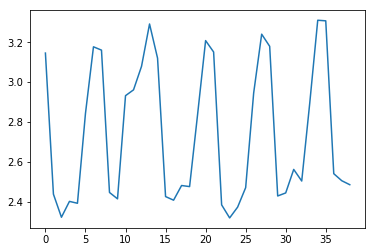

In [24]:
plt.plot(testpreds[129])

In [25]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [26]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.752316   
air_0164b9927d20bcc3_2017-04-23              1.308842   
air_0241aa3964b7f861_2017-04-23              2.392587   
air_0328696196e46f18_2017-04-23              2.157078   
air_034a3d5b40d5b1b1_2017-04-23              3.513076   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.767949  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.701883  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.941766  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.645836  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.551323

In [27]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [28]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [29]:
submission.to_csv("../submission/l5_3000_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')